In [1]:
# !pip install seaborn --upgrade

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import random
import pickle

from matplotlib.colors import ListedColormap
from scipy import stats
from statsmodels.miscmodels.ordinal_model import OrderedModel
from tqdm.notebook import tqdm

In [5]:
import warnings
import copy
warnings.filterwarnings(action="ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.')
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action="ignore", category=pd.errors.PerformanceWarning)

In [6]:
from jupyter_utils import style, mean_std, display_test, display_group_test, \
    scatter_annotate, show_corrtest_mask_corr, pointplot, pointplot_horizontal, add_grey, \
    prep_horizontal_pointplot_errobar_data, map_model, prep_LM_pointplot, draw_sample_with_replacement, t_test
from ortogonolize_utils import draw_scatter, draw_corrected_scatter
from ortogonolize_utils import compute_coefficient, compute_ortogonolized_coefficient, compute_ortogonolized_logit

In [7]:
sns.set_theme(style="whitegrid")

In [8]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/'

In [9]:
PATH_FIG = '/Users/galina.ryazanskaya/Downloads/thesis?/figures/ru/'

## merge data with psychosocial data

In [10]:
df = pd.read_csv(PATH +'rus_merged_psychosocial_data.csv', index_col=0)
df = df[df.index.notnull()]
df.rename(columns={'dep.severity-1': 'dep.severity',
                  'HDRS-17.score-1': 'HDRS-17',
                   'panss-1-td': 'panss_td',
                   'panss-1-total': 'panss_total', 
                   'panss-n-1-total': 'panss_neg', 
                   'panss-o-1-total': 'panss_o',
                   'panss-p-1-total': 'panss_pos', 
                   'sans-1-total': 'sans',
                   'saps-ftd-1-total': 'saps_ftd', 
                   'sops-1-total': 'sops_total', 
                   'sops-c-total': 'sops_c',
                   'sops-d-total': 'sops_d', 
                   'sops-n-total': 'sops_n', 
                   'sops-p-total': 'sops_p'
                  }, inplace=True)
df['index'] = df.index
df.drop_duplicates(inplace=True, subset='index')
df.drop(columns=['index'], inplace=True)

In [11]:
len(df)

176

In [12]:
res_df = pd.read_csv(PATH + 'processed_values/ru_both.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [13]:
res_df.columns = pd.MultiIndex.from_tuples([(c[0], c[1], c[2].replace('sporb', 'sprob')) for c in res_df.columns], names=('TASK', None, None))

In [14]:
len(res_df)

183

In [15]:
dfi = [i.replace('-', '').replace('S', 'PD1') for i in df.index]
df.index = dfi
# res_df.index = [i.replace('S', 'PD1') for i in res_df.index]
rdfi = [i.split('_')[0].replace('S', 'PD1') for i in res_df.index]

missing_psy = set(rdfi).difference(set(dfi))
missing_psy

{'PN005', 'PN006', 'PN012', 'PN014', 'PN019', 'PN238', 'PN327'}

In [16]:
missing_psy = [i for i in res_df.index if i.split('_')[0] in missing_psy]
res_df.drop(missing_psy, inplace=True)

In [17]:
len(res_df)

176

In [18]:
missing_text = set(dfi).difference(set(rdfi))
assert not missing_text

In [19]:
non_start_timepoint = [i for i in res_df.index if i.split('_')[-1] != '1']
res_df.drop(non_start_timepoint, inplace=True)

In [20]:
# res_df.loc['PD101_1'].dropna()

In [21]:
rdfi_filtered = [i.split('_')[0].replace('S', 'PD1') for i in res_df.index]
res_df.index = rdfi_filtered

## features of raw texts

In [22]:
raw = pd.read_csv(PATH+'rus_transcript_lex_by_task_with_dots.tsv', sep='\t', index_col=0)

In [23]:
ids_to_drop = [i for i in raw.index if i.split('_')[0] not in res_df.index]

In [24]:
raw.drop(index=ids_to_drop, inplace=True)

In [25]:
raw.index = [i.split('_')[0] for i in raw.index]

In [26]:
raw.isna().sum(axis=0).sum()

1060

In [27]:
# raw.applymap(lambda x: len(x.split('.')) if not pd.isna(x) else np.nan).mean(axis=1).hist()

## look at tasks

In [28]:
task_available = raw.applymap(lambda x: 1 if not pd.isna(x) else x)

In [29]:
len(task_available)

176

In [30]:
task_available['diagnosis.type'] = df['diagnosis.type']

In [31]:
task_available.count()

adventure         99
bench             28
chair             75
party             35
present           81
sportsman         96
table             30
trip              40
winterday         40
diagnosis.type    49
dtype: int64

In [32]:
task_available.groupby('diagnosis.type').count()

,adventure,bench,chair,party,present,sportsman,table,trip,winterday
diagnosis.type,,,,,,,,,
dep,14,0,14,0,13,14,0,0,0
sz,30,0,17,0,21,28,0,1,0


In [33]:
task_available.groupby('diagnosis.type').count()[task_available.groupby('diagnosis.type').count() > 0].dropna(axis=1)

,adventure,chair,present,sportsman
diagnosis.type,,,,
dep,14,14,13,14
sz,30,17,21,28


In [34]:
def drop_person(row):
    for task in ('adventure', 'chair','present','sportsman'):
        if not pd.isna(row[task]):
            return False
    return True

In [35]:
ids_with_at_least_one_task = task_available[~task_available.apply(drop_person, axis=1)].index

In [36]:
df = df.loc[ids_with_at_least_one_task]

In [37]:
TASKS = ['adventure', 'chair','present','sportsman']

In [38]:
res_df = res_df.loc[ids_with_at_least_one_task, TASKS]

In [39]:
compare_task_lens_df = pd.DataFrame(columns=TASKS)

In [40]:
compare_task_lens_df.loc['mean_sent_len'] = res_df[[(task, 'syntactic', 'mean_sent_len') for task in TASKS]].mean().droplevel([1, 2])

In [41]:
compare_task_lens_df.loc['n_sents'] = res_df[[(task, 'syntactic', 'n_sents') for task in TASKS]].mean().droplevel([1, 2])

In [42]:
compare_task_lens_df.loc['n_words'] =  res_df[[(task, 'lexical', 'n_words') for task in TASKS]].mean().droplevel([1, 2])

In [43]:
compare_task_lens_df

,adventure,chair,present,sportsman
mean_sent_len,7.165963,8.668295,9.724067,7.770671
n_sents,19.393939,18.506667,14.000000,17.635417
n_words,137.979798,159.866667,127.802469,131.322917


In [44]:
def task_data(df, task, keep_target=True, fill_synt=True):
    subset = df[task].dropna(axis=0, how='all')
    if fill_synt:
        subset['syntactic'] = subset['syntactic'].fillna(0.0)
    if keep_target:
        subset = pd.concat([subset, df['target'].loc[subset.index]], axis=1)
    return subset

In [45]:
style(task_data(res_df, 'chair', keep_target=False)[[('syntactic', 'mean_sent_len'), ('syntactic', 'n_sents'), ('lexical', 'n_words')]].corr())

In [46]:
style(task_data(res_df, 'adventure', keep_target=False)[[('syntactic', 'mean_sent_len'), ('syntactic', 'n_sents'), ('lexical', 'n_words')]].corr())

In [47]:
style(task_data(res_df, 'sportsman', keep_target=False)[[('syntactic', 'mean_sent_len'), ('syntactic', 'n_sents'), ('lexical', 'n_words')]].corr())

In [48]:
style(task_data(res_df, 'present', keep_target=False)[[('syntactic', 'mean_sent_len'), ('syntactic', 'n_sents'), ('lexical', 'n_words')]].corr())

In [49]:
def aplly_to_all_tasks(df, f, tasks=TASKS, to_df=True, *args, **kwargs):
    res = {}
    for task in tasks:
        data = task_data(df, task)
        res[task] = f(data, *args, **kwargs)
    if to_df:
        if all(isinstance(v, pd.Series) for v in res.values()):
            return pd.DataFrame(res)
        elif all(isinstance(v, pd.DataFrame) for v in res.values()):
            return pd.concat(list(res.values()), keys=list(res.keys()), names=['task'], axis=1)
        else:
            return res
    return res

## psychosocial statistics

In [50]:
def fill_diagnosis_type(row):
    dt = row['diagnosis.type']
    if not pd.isna(dt):
        return dt
    else:
        if not pd.isna(row['td.severity']):
            return 'control_psy'
        else:
            return 'control'

In [51]:
df['diagnosis.type'] = df.apply(fill_diagnosis_type, axis=1)

In [52]:
sz = df[df['diagnosis.type'] == 'sz']
dep = df[df['diagnosis.type'] == 'dep']
control = df[df['diagnosis.group'] == 'control']
control_psy = df[df['diagnosis.type'] == 'control_psy']

In [53]:
df.columns

Index(['age', 'dep.scale', 'dep.severity', 'group.code', 'diagnosis.group',
       'diagnosis.type', 'diagnosis_code', 'diagnosis_eng', 'diagnosis_rus',
       'education.level.code', 'education.level.eng', 'education.years',
       'exacerbation', 'HDRS-17', 'longitudinal', 'panss_td', 'panss_total',
       'panss_neg', 'panss_o', 'panss_pos', 'rehospitalization', 'sans',
       'saps_ftd', 'sex', 'sops_total', 'sops_c', 'sops_d', 'sops_n', 'sops_p',
       'td.scales', 'td.severity'],
      dtype='object')

In [54]:
df['diagnosis.group'].value_counts()

control    102
patient     49
Name: diagnosis.group, dtype: int64

In [55]:
df['diagnosis.type'].value_counts()

control        72
sz             31
control_psy    30
dep            18
Name: diagnosis.type, dtype: int64

In [56]:
df['dep.scale'].value_counts()

HDRS    51
QIDS    28
Name: dep.scale, dtype: int64

In [57]:
df['td.scales'].value_counts()

PANSS       28
SCL-90-R    28
SAPS        21
Name: td.scales, dtype: int64

In [58]:
df.groupby('diagnosis.type')[['diagnosis_code', 'diagnosis_eng']].value_counts()

diagnosis.type  diagnosis_code  diagnosis_eng                                    
dep             F31             bipolar.affective.disorder                            6
                F60.31          borderline.personality.disorder                       3
                F31.4           bipolar.affective.disorder.severe                     2
                F31.5           bipolar.affective.disorder.severe.psychotic           2
                F33             recurrent.depressive.disorder                         2
                F32.1           depressive.episode.moderate                           1
                F33.3           recurrent.depressive.disorder.severe.psychotic        1
                F60             personality.disorder                                  1
sz              F20             schizophrenia                                        20
                F25             schizoaffective.disorder                              8
                F21             schizo

### select target cols

In [59]:
target_cols = ['sex', 'age', 'education.years', 
               'diagnosis.group', 'diagnosis.type',
               'dep.severity', 'td.severity']

In [60]:
# panss_cols = [col for col in df.columns if col.startswith('panss')]
panss_cols = ['panss_td', 'panss_total', 'panss_neg', 'panss_pos', 'panss_o']
sans_cols = [col for col in df.columns if col.startswith('sans')]
saps_cols = [col for col in df.columns if col.startswith('saps')]
sops_cols = [col for col in df.columns if col.startswith('sops')]

In [61]:
numeric_target = ['education.years','dep.severity','td.severity'] + panss_cols

In [62]:
# sz.count()[sz.count() > 0]

In [63]:
# dep.count()[dep.count() > 0]

In [64]:
sz['sex'].value_counts()

female    25
male       6
Name: sex, dtype: int64

In [65]:
mean_std(sz, target_cols + panss_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:118: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,27.13 (7.14),13.32 (2.41),0.58 (0.85),0.84 (0.73),10.03 (3.74),69.79 (16.13),22.93 (8.59),15.9 (4.92),30.97 (8.42)


In [66]:
mean_std(sz, target_cols + panss_cols, 'sex')

,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
sex,,,,,,,,,
female,27.8 (7.53),13.56 (2.48),0.72 (0.89),0.8 (0.76),9.43 (3.62),69.13 (15.38),22.52 (7.79),15.3 (4.91),31.3 (9.08)
male,24.33 (4.72),12.33 (1.97),0.0 (0.0),1.0 (0.63),12.33 (3.56),72.33 (20.16),24.5 (11.93),18.17 (4.67),29.67 (5.65)


In [67]:
r = mean_std(sz, ['dep.severity', 'td.severity'] + panss_cols)
r.loc['max'] = pd.Series([4, 4, 28, 210, 49, 49, 112], index=r.columns)
r.loc['min'] = pd.Series([0, 0, 2, 30, 7, 7, 16], index=r.columns)
r.loc['share'] = r.loc['value'].apply(lambda x: float(x.split(' ')[0])) / r.loc['max'] 

In [68]:
r

,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,0.58 (0.85),0.84 (0.73),10.03 (3.74),69.79 (16.13),22.93 (8.59),15.9 (4.92),30.97 (8.42)
max,4,4,28,210,49,49,112
min,0,0,2,30,7,7,16
share,0.145,0.21,0.358214,0.332333,0.467959,0.32449,0.276518


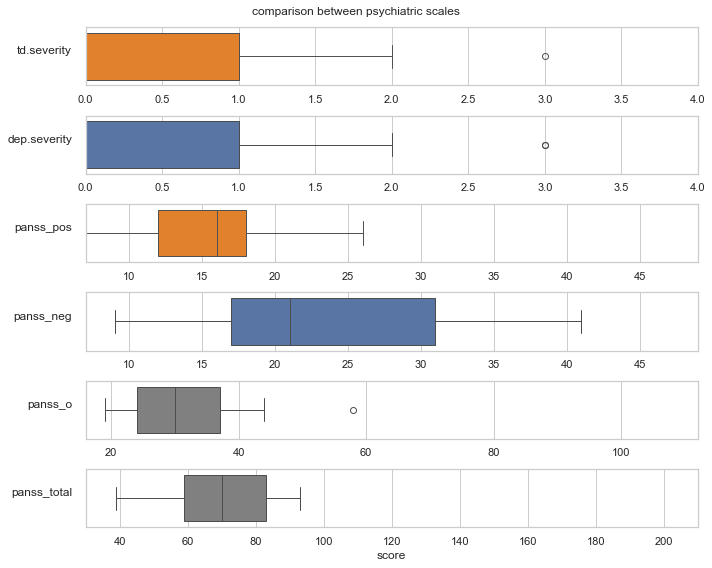

In [69]:
fig, axes = plt.subplots(6, 1, figsize=(10, 8))
fig.suptitle('comparison between psychiatric scales')
sns.boxplot(x=sz['td.severity'], ax=axes[0], color='tab:orange')
axes[0].set_xlim(0, 4)
axes[0].set_xlabel('')
axes[0].set_ylabel('td.severity', rotation='horizontal', ha='right')
sns.boxplot(x=sz['dep.severity'], ax=axes[1])
axes[1].set_xlim(0, 4)
axes[1].set_xlabel('')
axes[1].set_ylabel('dep.severity', rotation='horizontal', ha='right')
sns.boxplot(x=sz['panss_pos'], ax=axes[2], color='tab:orange')
axes[2].set_xlim(7, 49)
axes[2].set_xlabel('')
axes[2].set_ylabel('panss_pos', rotation='horizontal', ha='right')
sns.boxplot(x=sz['panss_neg'], ax=axes[3])
axes[3].set_xlim(7, 49)
axes[3].set_xlabel('')
axes[3].set_ylabel('panss_neg', rotation='horizontal', ha='right')
sns.boxplot(x=sz['panss_o'], ax=axes[4], color='grey')
axes[4].set_xlim(16, 112)
axes[4].set_xlabel('')
axes[4].set_ylabel('panss_o', rotation='horizontal', ha='right')
sns.boxplot(x=sz['panss_total'], ax=axes[5], color='grey')
axes[5].set_xlim(30, 210)
axes[5].set_xlabel('')
axes[5].set_ylabel('panss_total', rotation='horizontal', ha='right')
axes[5].set_xlabel('score')
fig.tight_layout();
plt.savefig(f'{PATH_FIG}psychiatric.png', dpi=150, bbox_inches = 'tight')

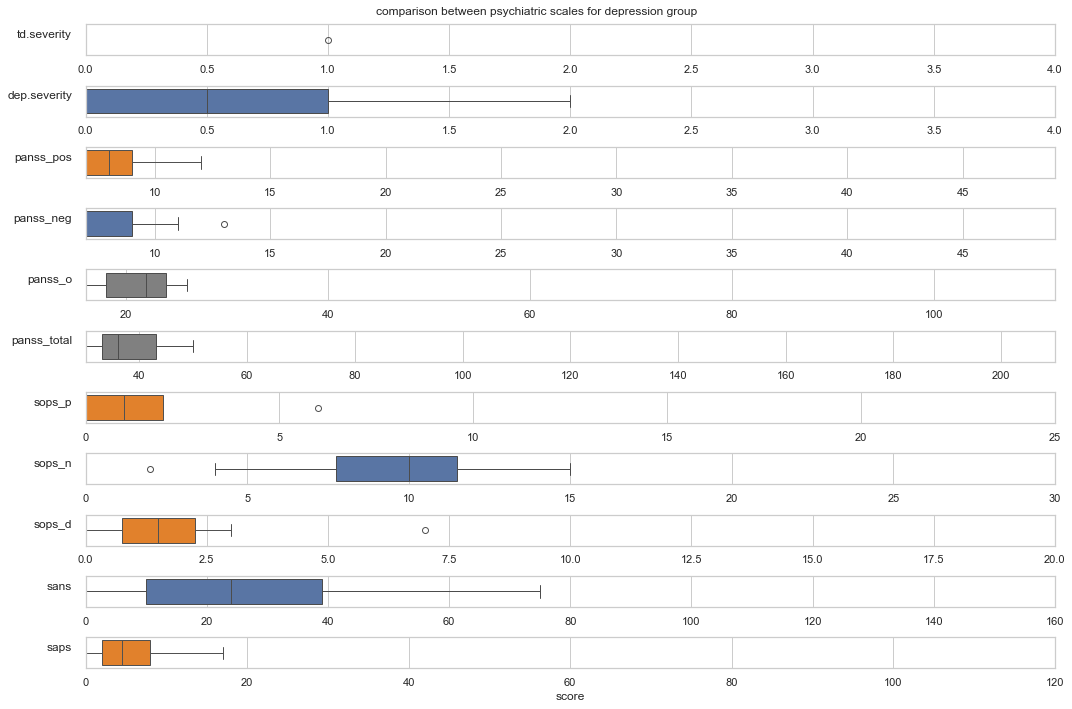

In [70]:
fig, axes = plt.subplots(11, 1, figsize=(15, 10))
fig.suptitle('comparison between psychiatric scales for depression group')
sns.boxplot(x=dep['td.severity'], ax=axes[0], color='tab:orange')
axes[0].set_xlim(0, 4)
axes[0].set_xlabel('')
axes[0].set_ylabel('td.severity', rotation='horizontal', ha='right')
sns.boxplot(x=dep['dep.severity'], ax=axes[1])
axes[1].set_xlim(0, 4)
axes[1].set_xlabel('')
axes[1].set_ylabel('dep.severity', rotation='horizontal', ha='right')
sns.boxplot(x=dep['panss_pos'], ax=axes[2], color='tab:orange')
axes[2].set_xlim(7, 49)
axes[2].set_xlabel('')
axes[2].set_ylabel('panss_pos', rotation='horizontal', ha='right')
sns.boxplot(x=dep['panss_neg'], ax=axes[3])
axes[3].set_xlim(7, 49)
axes[3].set_xlabel('')
axes[3].set_ylabel('panss_neg', rotation='horizontal', ha='right')
sns.boxplot(x=dep['panss_o'], ax=axes[4], color='grey')
axes[4].set_xlim(16, 112)
axes[4].set_xlabel('')
axes[4].set_ylabel('panss_o', rotation='horizontal', ha='right')
sns.boxplot(x=dep['panss_total'], ax=axes[5], color='grey')
axes[5].set_xlim(30, 210)
axes[5].set_xlabel('')
axes[5].set_ylabel('panss_total', rotation='horizontal', ha='right')
sns.boxplot(x=dep['sops_p'], ax=axes[6], color='tab:orange')
axes[6].set_xlim(0, 25)
axes[6].set_xlabel('')
axes[6].set_ylabel('sops_p', rotation='horizontal', ha='right')
axes[6].set_xlabel('')
sns.boxplot(x=dep['sops_n'], ax=axes[7])
axes[7].set_xlim(0, 30)
axes[7].set_xlabel('')
axes[7].set_ylabel('sops_n', rotation='horizontal', ha='right')
axes[7].set_xlabel('')
sns.boxplot(x=dep['sops_d'], ax=axes[8], color='tab:orange')
axes[8].set_xlim(0, 20)
axes[8].set_xlabel('')
axes[8].set_ylabel('sops_d', rotation='horizontal', ha='right')
axes[8].set_xlabel('')
sns.boxplot(x=dep['sans'], ax=axes[9])
axes[9].set_xlim(0, 160)
axes[9].set_xlabel('')
axes[9].set_ylabel('sans', rotation='horizontal', ha='right')
axes[9].set_xlabel('')
sns.boxplot(x=dep['saps_ftd'], ax=axes[10], color='tab:orange')
axes[10].set_xlim(0, 120)
axes[10].set_xlabel('')
axes[10].set_ylabel('saps', rotation='horizontal', ha='right')
axes[10].set_xlabel('')

axes[10].set_xlabel('score')
fig.tight_layout();
plt.savefig(f'{PATH_FIG}psychiatric_dep.png', dpi=150, bbox_inches = 'tight')

In [71]:
dep['sex'].value_counts()

female    18
Name: sex, dtype: int64

In [72]:
mean_std(dep, target_cols + panss_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:118: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,20.89 (3.71),12.67 (1.94),0.56 (0.62),0.06 (0.24),4.42 (0.9),37.92 (5.89),8.31 (1.97),8.46 (1.94),21.15 (3.58)


In [73]:
dep['panss_o'].count()

13

In [74]:
control['sex'].value_counts()

female    75
male      27
Name: sex, dtype: int64

In [75]:
mean_std(control, target_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:118: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity
value,39.75 (19.15),15.74 (2.57),0.0 (0.0),0.0 (0.0)


In [76]:
mean_std(control, target_cols, 'sex')

,age,education.years,dep.severity,td.severity
sex,,,,
female,38.25 (18.85),15.39 (2.39),0.0 (0.0),0.0 (0.0)
male,43.93 (19.73),16.7 (2.83),0.0 (0.0),0.0 (0.0)


In [77]:
control_psy['sex'].value_counts()

female    26
male       4
Name: sex, dtype: int64

In [78]:
mean_std(control_psy, target_cols + panss_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:118: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,25.0 (7.4),15.43 (2.13),0.0 (0.0),0.0 (0.0),4.36 (1.0),30.77 (1.54),7.23 (0.53),7.23 (0.61),16.32 (0.95)


In [79]:
mean_std(control_psy, target_cols + panss_cols, 'sex')

,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
sex,,,,,,,,,
female,25.42 (7.8),15.42 (1.7),0.0 (0.0),0.0 (0.0),4.4 (1.05),30.85 (1.6),7.25 (0.55),7.25 (0.64),16.35 (0.99)
male,22.25 (3.3),15.5 (4.43),0.0 (0.0),0.0 (0.0),4.0 (0.0),30.0 (0.0),7.0 (0.0),7.0 (0.0),16.0 (0.0)


In [80]:
control.groupby('sex')['panss_total'].count()

sex
female    20
male       2
Name: panss_total, dtype: int64

In [81]:
# control_psy.count()[control_psy.count() > 0]

In [82]:
# df.dropna(axis=0, thresh=30).iloc[0]

### test for differences

age

In [83]:
stats.ttest_ind(control['age'], sz['age'], nan_policy='omit')

Ttest_indResult(statistic=3.5871243575285408, pvalue=0.00047085918746073396)

In [84]:
stats.ttest_ind(control_psy['age'], sz['age'], nan_policy='omit')

Ttest_indResult(statistic=-1.143255849283786, pvalue=0.2575501479174914)

In [85]:
stats.ttest_ind(control_psy['age'], dep['age'], nan_policy='omit')

Ttest_indResult(statistic=2.1899209175114764, pvalue=0.033638603323606325)

eduaction years

In [86]:
stats.ttest_ind(control['education.years'], sz['education.years'], nan_policy='omit')

Ttest_indResult(statistic=4.653034980872723, pvalue=7.949204742694471e-06)

In [87]:
stats.ttest_ind(control_psy['education.years'], sz['education.years'], nan_policy='omit')

Ttest_indResult(statistic=3.618089157043871, pvalue=0.0006167702505040491)

In [88]:
stats.ttest_ind(control_psy['education.years'], dep['education.years'], nan_policy='omit')

Ttest_indResult(statistic=4.502842757884748, pvalue=4.561269295083997e-05)

sex

In [89]:
a = 0.05

In [90]:
s_t_sex, res_t_sex = display_group_test(control, numeric_target, 'sex', stats.ttest_ind, stat_name='t', alpha=a)
style(res_t_sex)

,t,p,sig,abs_t
education.years,2.321636,0.022302,True,2.321636
dep.severity,nan,nan,False,nan
td.severity,nan,nan,False,nan
panss_td,-0.528886,0.602706,False,0.528886
panss_total,-0.735628,0.470497,False,0.735628
panss_neg,-0.628695,0.536664,False,0.628695
panss_pos,-0.541530,0.594124,False,0.541530
panss_o,-0.490038,0.629439,False,0.490038


In [91]:
s_t_sex, res_t_sex = display_group_test(control_psy, numeric_target, 'sex', stats.ttest_ind, stat_name='t', alpha=a)
style(res_t_sex)

,t,p,sig,abs_t
education.years,0.066128,0.947746,False,0.066128
dep.severity,nan,nan,False,nan
td.severity,nan,nan,False,nan
panss_td,-0.528886,0.602706,False,0.528886
panss_total,-0.735628,0.470497,False,0.735628
panss_neg,-0.628695,0.536664,False,0.628695
panss_pos,-0.541530,0.594124,False,0.541530
panss_o,-0.490038,0.629439,False,0.490038


In [92]:
s_t_sex, res_t_sex = display_group_test(sz, numeric_target, 'sex', stats.ttest_ind, stat_name='t', alpha=a)
style(res_t_sex)

,t,p,sig,abs_t
education.years,-1.122772,0.270744,False,1.122772
dep.severity,-1.954622,0.060329,False,1.954622
td.severity,0.592289,0.558247,False,0.592289
panss_td,1.753714,0.090826,False,1.753714
panss_total,0.426912,0.672829,False,0.426912
panss_neg,0.495589,0.624194,False,0.495589
panss_pos,1.282777,0.210473,False,1.282777
panss_o,-0.418000,0.679253,False,0.418000


### correlation between target variables

In [93]:
# display corr test

In [94]:
x, y = display_test(df, numeric_target, 'age', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
education.years,0.468966,0.0,True,0.468966
panss_neg,0.383708,0.001749,True,0.383708


In [95]:
x, y = display_test(df, numeric_target, 'education.years', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
panss_o,-0.407709,0.000826,True,0.407709
dep.severity,-0.331386,0.002852,True,0.331386


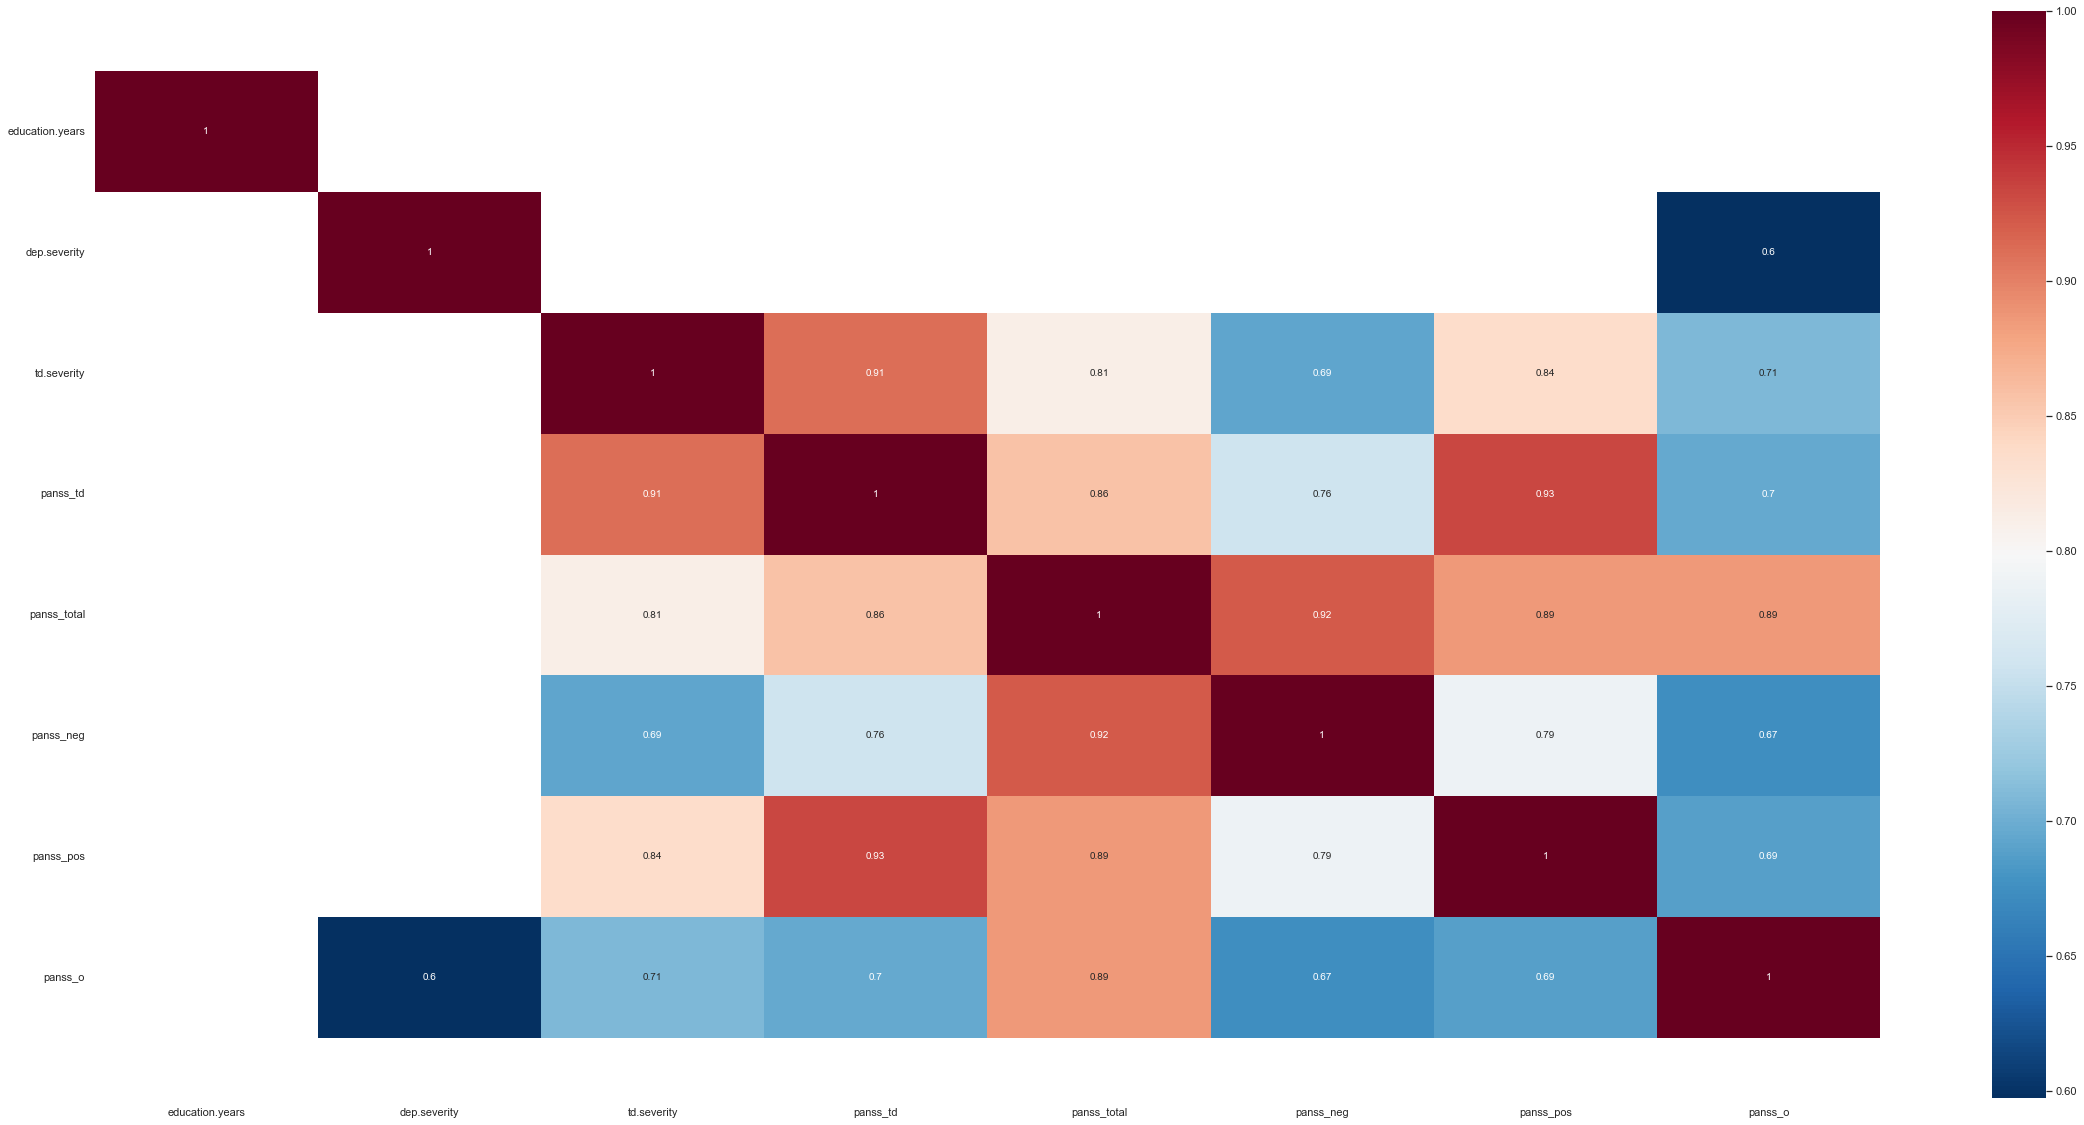

In [96]:
target_corr_res = show_corrtest_mask_corr(df[numeric_target])

## scores

In [97]:
# res_df

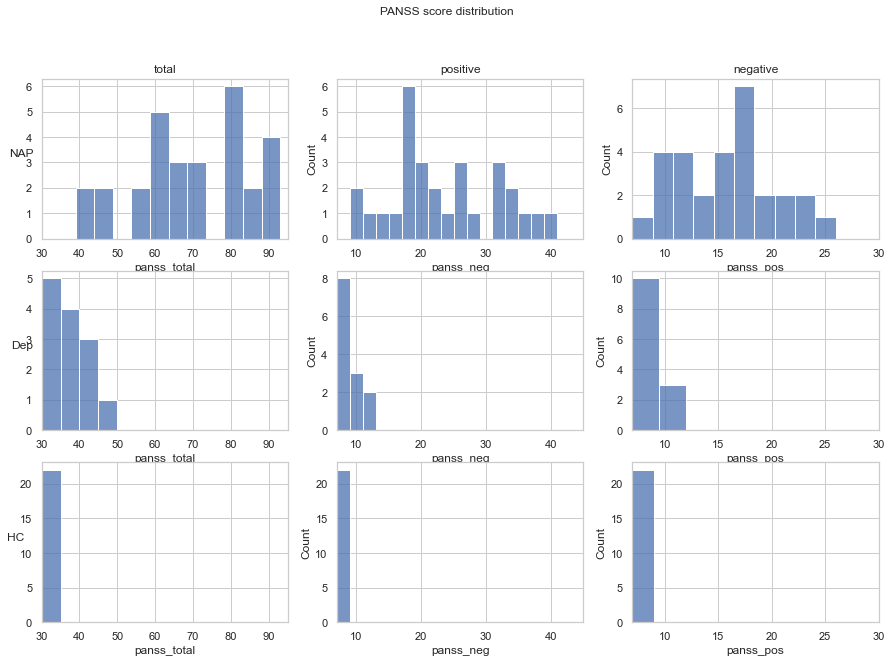

In [98]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('PANSS score distribution')


sns.histplot(sz['panss_total'], ax=axes[0, 0], binwidth=5)
axes[0, 0].set_xlim(30, 95)
sns.histplot(dep['panss_total'], ax=axes[1, 0], binwidth=5)
axes[1, 0].set_xlim(30, 95)
sns.histplot(control_psy['panss_total'], ax=axes[2, 0], binwidth=5)
axes[2, 0].set_xlim(30, 95)
sns.histplot(sz['panss_neg'], ax=axes[0, 1], binwidth=2)
axes[0, 1].set_xlim(7, 45)
sns.histplot(dep['panss_neg'], ax=axes[1, 1], binwidth=2)
axes[1, 1].set_xlim(7, 45)
sns.histplot(control_psy['panss_neg'], ax=axes[2, 1], binwidth=2)
axes[2, 1].set_xlim(7, 45)
sns.histplot(sz['panss_pos'], ax=axes[0, 2], binwidth=2)
axes[0, 2].set_xlim(7, 30)
sns.histplot(dep['panss_pos'], ax=axes[1, 2], binwidth=2)
axes[1, 2].set_xlim(7, 30)
sns.histplot(control_psy['panss_pos'], ax=axes[2, 2], binwidth=2)
axes[2, 2].set_xlim(7, 30)

for ax, col in zip(axes[0], ('total', 'positive', 'negative')):
    ax.set_title(col)

for ax, row in zip(axes[:,0], ('NAP', 'Dep', 'HC')):
    ax.set_ylabel(row, rotation=0, size='large')

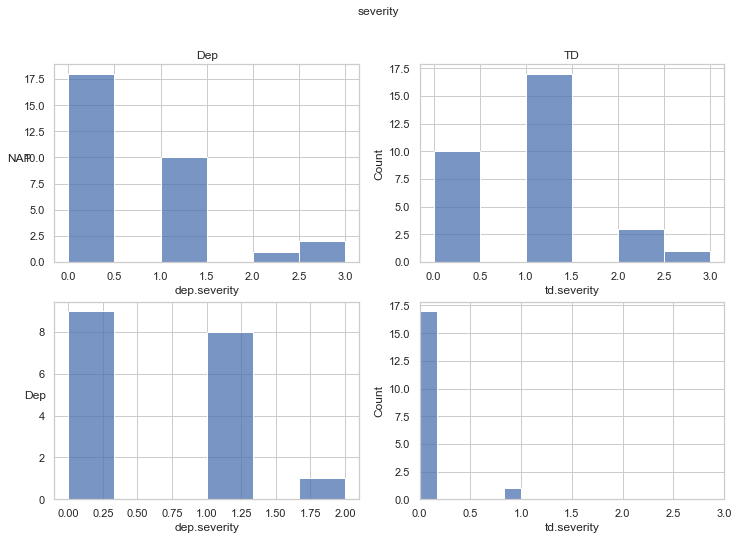

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('severity')


sns.histplot(sz['dep.severity'], ax=axes[0, 0])
sns.histplot(dep['dep.severity'], ax=axes[1, 0])
sns.histplot(sz['td.severity'], ax=axes[0, 1])
sns.histplot(dep['td.severity'], ax=axes[1, 1])
axes[1, 1].set_xlim(0, 3)

for ax, col in zip(axes[0], ('Dep', 'TD')):
    ax.set_title(col)

for ax, row in zip(axes[:,0], ('NAP', 'Dep')):
    ax.set_ylabel(row, rotation=0, size='large')

### merge psychoscial data to scores

In [100]:
merge_df = res_df.copy()
for col in target_cols + panss_cols:
    merge_df[('target', 'target', col)] = df[col]

In [101]:
cols_tasks = res_df['sportsman'].columns
cols_LM = [col for col in res_df['sportsman'] if col[0] == 'LM']
cols_synt = [col for col in res_df['sportsman'] if col[0] == 'syntactic']
cols_lex = [col for col in res_df['sportsman'] if col[0] == 'lexical']
cols_graph = [col for col in res_df['sportsman'] if col[0] == 'graph']

In [102]:
POS_to_use = ('ADJ', 'ADV', 'AUX', 'CCONJ', 'DET','NOUN', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'PART')
pos = set([x[1] for x in cols_synt if x[1].isupper()])

pos.difference(set(('ADJ', 'ADV', 'AUX', 'CCONJ', 'DET','NOUN', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'PART')))

{'ADP', 'INTJ', 'NUM', 'PUNCT', 'SPACE', 'X'}

In [103]:
pos_cols_to_drop = [(task, c[0], c[1]) for task in TASKS for c in cols_synt if c[1].isupper() and c[1] not in POS_to_use and (task, c[0], c[1]) in merge_df.columns]

In [104]:
pos_cols_to_drop

[('adventure', 'syntactic', 'ADP'),
 ('adventure', 'syntactic', 'NUM'),
 ('adventure', 'syntactic', 'PUNCT'),
 ('adventure', 'syntactic', 'SPACE'),
 ('adventure', 'syntactic', 'X'),
 ('chair', 'syntactic', 'ADP'),
 ('chair', 'syntactic', 'INTJ'),
 ('chair', 'syntactic', 'NUM'),
 ('chair', 'syntactic', 'PUNCT'),
 ('chair', 'syntactic', 'SPACE'),
 ('present', 'syntactic', 'ADP'),
 ('present', 'syntactic', 'NUM'),
 ('present', 'syntactic', 'PUNCT'),
 ('present', 'syntactic', 'SPACE'),
 ('present', 'syntactic', 'X'),
 ('sportsman', 'syntactic', 'ADP'),
 ('sportsman', 'syntactic', 'INTJ'),
 ('sportsman', 'syntactic', 'NUM'),
 ('sportsman', 'syntactic', 'PUNCT'),
 ('sportsman', 'syntactic', 'SPACE'),
 ('sportsman', 'syntactic', 'X')]

In [105]:
merge_df.drop(columns=pos_cols_to_drop, inplace=True)

In [106]:
merge_df.columns.unique(level='TASK')

Index(['adventure', 'chair', 'present', 'sportsman', 'target'], dtype='object', name='TASK')

In [107]:
cols_synt = [col for col in merge_df['chair'] if col[0] == 'syntactic']
cols_tasks = cols_synt + cols_LM + cols_lex + cols_graph

In [108]:
def corr(df, target):
    return df[~pd.isnull(df[target])].corr()[target]

In [109]:
def corr_thresh(df, target, thresh=0.3, drop_target=True):
    corr_tgt = corr(df, target)
    if drop_target:
        corr_tgt.drop('target', inplace=True)
    return corr_tgt[abs(corr_tgt) >= thresh]

In [110]:
def ttest(df, test_columns, group):
    s_t, res_t = display_group_test(df, test_columns, group, stats.ttest_ind, stat_name='t', alpha=a)
    return res_t[['t', 'p']]

### psychosocial variables vs metrics

In [111]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'age')))

In [112]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'education.years')))

In [113]:
control = merge_df[merge_df[('target', 'target', 'diagnosis.group')] == 'control']

In [114]:
style(aplly_to_all_tasks(control, corr_thresh, target=('target', 'age'), thresh=0.4))

In [115]:
style(aplly_to_all_tasks(control, corr_thresh, target=('target', 'education.years'), thresh=0.4))

### psychiatric variables vs metrics

In [116]:
def thresh_any_task(df, col='p', tasks=TASKS, thresh=0.05):
    return df[df.apply(lambda row: any([row[task][col] < thresh for task in tasks]), axis=1)]

In [117]:
res = aplly_to_all_tasks(merge_df, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.group'))
style(thresh_any_task(res, thresh=0.01))

In [118]:
def ttest_select(df, test_two_groups, colname, cols_tasks=cols_tasks):
    groups = df[df[('target', colname)].isin(test_two_groups)]
    s_t, res_t = display_group_test(groups, cols_tasks, ('target', colname), test=stats.ttest_ind, stat_name='t', alpha=a)
    return res_t['t']

In [119]:
chair = task_data(merge_df, 'chair')

In [120]:
ttest_select(chair, ('sz', 'control_psy'), 'diagnosis.type')

(syntactic, ADJ)              0.490088
(syntactic, ADV)             -0.294076
(syntactic, AUX)             -0.475141
(syntactic, CCONJ)             0.96283
(syntactic, DET)             -0.003997
(syntactic, NOUN)             1.159196
(syntactic, PART)            -2.935745
(syntactic, PRON)             0.398696
(syntactic, PROPN)           -1.389632
(syntactic, SCONJ)           -0.307485
(syntactic, VERB)             0.272148
(syntactic, max_sent_len)     2.101802
(syntactic, mean_sent_len)    3.331125
(syntactic, min_sent_len)     0.793557
(syntactic, n_sents)           3.35693
(syntactic, std_sent_len)     0.644918
(LM, m_bert_cgcoh)           -0.431062
(LM, m_bert_gcoh)             0.102419
(LM, m_bert_lcoh)             0.765065
(LM, m_bert_scoh)             0.653857
(LM, m_cgcoh)                 1.051026
(LM, m_gcoh)                  1.321195
(LM, m_lcoh)                  1.510666
(LM, m_raw_cgcoh)             0.077593
(LM, m_raw_gcoh)              1.058816
(LM, m_raw_lcoh)         

In [121]:
test_two_groups = ('sz', 'control_psy')
groups = merge_df[merge_df[('target', 'target','diagnosis.type')].isin(test_two_groups)]
res = aplly_to_all_tasks(groups, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.type'))
style(thresh_any_task(res, thresh=0.005))

In [122]:
test_two_groups = ('sz', 'control')
groups = merge_df[merge_df[('target', 'target','diagnosis.type')].isin(test_two_groups)]
res = aplly_to_all_tasks(groups, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.type'))
style(thresh_any_task(res, thresh=0.005))

In [123]:
test_two_groups = ('dep', 'control_psy')
groups = merge_df[merge_df[('target', 'target','diagnosis.type')].isin(test_two_groups)]
res = aplly_to_all_tasks(groups, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.type'))
style(thresh_any_task(res, thresh=0.005))

In [124]:
test_two_groups = ('dep', 'sz')
groups = merge_df[merge_df[('target', 'target','diagnosis.type')].isin(test_two_groups)]
res = aplly_to_all_tasks(groups, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.type'))
style(thresh_any_task(res, thresh=0.005))

### Corr

In [125]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_total')))

In [126]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_pos')))

In [127]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_neg')))

In [128]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_o')))

## Ordered Model

In [129]:
psy_td = df[~pd.isna(df['td.severity'])]

In [130]:
psy_td['td.severity'] = psy_td.loc[:,'td.severity'].astype(pd.CategoricalDtype(ordered=True))
psy_td = psy_td.loc[psy_td[['td.severity', 'panss_total', 'panss_pos', 'panss_neg']].dropna().index]

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_7183/3739057385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psy_td['td.severity'] = psy_td.loc[:,'td.severity'].astype(pd.CategoricalDtype(ordered=True))


In [131]:
def compute_pseudo_rsquared_ordered(df, target_col, predictor_cols):
    df = df.loc[df[[target_col] + predictor_cols].dropna().index]
    mod_prob = OrderedModel(df[target_col],
                        df[predictor_cols],
                        distr='probit')

    res_prob = mod_prob.fit(method='bfgs', disp=0)
    return res_prob.prsquared

In [132]:
compute_pseudo_rsquared_ordered(psy_td, 'td.severity', ['panss_total', 'panss_pos', 'panss_neg'])

0.6742463723003046

In [133]:
compute_pseudo_rsquared_ordered(psy_td, 'td.severity', ['panss_total', 'panss_pos'])

0.6665934072022907

In [134]:
compute_pseudo_rsquared_ordered(psy_td, 'td.severity', ['panss_total'])

0.5952968595542267

In [135]:
compute_pseudo_rsquared_ordered(psy_td, 'dep.severity', ['panss_neg'])

0.020654112989205275

In [136]:
compute_pseudo_rsquared_ordered(psy_td, 'dep.severity', ['panss_o'])

0.18924309868

In [137]:
compute_pseudo_rsquared_ordered(chair, ('target', 'dep.severity'), [('LM', 'm_cgcoh')])

0.06443780408932076

## Length

In [138]:
chair

LM                                                          \
      m_bert_cgcoh m_bert_gcoh m_bert_lcoh m_bert_scoh   m_cgcoh    m_gcoh   
N02       0.907379    0.894173    0.892854    0.778331  0.859000  0.838311   
N07       0.956381    0.955130    0.935352    0.933666  0.777727  0.734761   
N09       0.970384    0.964711    0.942394    0.925433  0.999755  0.999696   
N13       0.977305    0.966893    0.950994    0.923762  0.830714  0.816151   
N17       0.956933    0.940715    0.909069    0.925338  0.776746  0.699820   
...            ...         ...         ...         ...       ...       ...   
PN020     0.973917    0.970394    0.937589    0.950313  0.999079  0.998913   
PN021     0.960883    0.952544    0.929937    0.929935  0.917792  0.907508   
PD107     0.957607    0.943778    0.900488    0.894012  0.876956  0.864955   
PD115     0.954370    0.949186    0.909227    0.859706  0.975395  0.969217   
PD116     0.956023    0.932437    0.888154    0.903945  0.999995  0.999994   

                                                   ...          target  \
         m_lcoh m_raw_cgcoh m_raw_gcoh m_raw_lcoh  ... education.years   
N02    0.739677    0.649636   0.556826   0.286127  ...            20.0   
N07    0.602678    0.609947   0.576815   0.417359  ...            15.0   
N09    0.999152    0.709999   0.601621   0.166089  ...            16.0   
N13    0.731150    0.738125   0.684120   0.483674  ...            12.0   
N17    0.439527    0.782570   0.564025   0.347526  ...            12.0   
...         ...         ...        ...        ...  ...             ...   
PN020  0.997459    0.877891   0.828396   0.645872  ...            17.0   
PN021  0.819539    0.794307   0.774209   0.575791  ...            15.0   
PD107  0.735897    0.735200   0.695400   0.413663  ...            16.0   
PD115  0.961751    0.788089   0.759132   0.518692  ...            13.0   
PD116  0.999987    0.909133   0.836161   0.693803  ...            12.0   

                                                                        \
      diagnosis.group diagnosis.type dep.severity td.severity panss_td   
N02           control        control          NaN         NaN      NaN   
N07           control        control          NaN         NaN      NaN   
N09           control        control          NaN         NaN      NaN   
N13           control        control          NaN         NaN      NaN   
N17           control        control          NaN         NaN      NaN   
...               ...            ...          ...         ...      ...   
PN020         control    control_psy          0.0         0.0      4.0   
PN021         control    control_psy          0.0         0.0      4.0   
PD107         patient             sz          1.0         1.0      9.0   
PD115         patient             sz          0.0         0.0      9.0   
PD116         patient             sz          3.0         3.0     15.0   

                                               
      panss_total panss_neg panss_pos panss_o  
N02           NaN       NaN       NaN     NaN  
N07           NaN       NaN       NaN     NaN  
N09           NaN       NaN       NaN     NaN  
N13           NaN       NaN       NaN     NaN  
N17           NaN       NaN       NaN     NaN  
...           ...       ...       ...     ...  
PN020        30.0       7.0       7.0    16.0  
PN021        30.0       7.0       7.0    16.0  
PD107        60.0      22.0      10.0    28.0  
PD115        41.0       9.0      10.0    22.0  
PD116        83.0      21.0      18.0    44.0  

[75 rows x 54 columns]

In [139]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('syntactic', 'mean_sent_len'), thresh=0.15, drop_target=False).loc['target'])

,adventure,chair,present,sportsman
age,nan,0.342145,-0.173087,nan
dep.severity,nan,-0.250554,nan,-0.169931
education.years,nan,0.339751,nan,nan
panss_neg,-0.237326,-0.358061,-0.336585,nan
panss_o,-0.156362,-0.359784,-0.288190,nan
panss_pos,nan,-0.311077,-0.274064,nan
panss_td,nan,-0.238211,-0.267711,nan
panss_total,-0.199764,-0.373700,-0.327721,nan
td.severity,nan,-0.246204,-0.214338,nan


In [140]:
tasks_len = aplly_to_all_tasks(merge_df, corr_thresh, target=('syntactic', 'mean_sent_len'), thresh=0.5)
tasks_len.drop(index=[('syntactic', 'mean_sent_len')], inplace=True)
style(tasks_len)

In [141]:
tasks_len = aplly_to_all_tasks(merge_df, corr_thresh, target=('syntactic', 'mean_sent_len'), thresh=0.)
tasks_len.drop(index=[('syntactic', 'mean_sent_len')], inplace=True)

In [142]:
ex_df = pd.DataFrame()
for task in TASKS:
    df_ = pd.DataFrame()
    df_['metric'] = tasks_len[task]
    df_['task'] = task
    df_['index'] = [x[1] for x in df_.index]
    df_['type'] = [x[0] for x in df_.index]
    ex_df = pd.concat([ex_df, df_])

In [143]:
def catplot(data, x, y, hue, col=None, ax=None):
    sns.set_theme(style="whitegrid")

    # Draw a pointplot to show pulse as a function of three categorical factors
    g = sns.catplot(
        data=data, x=x, y=y, hue=hue, col=col,
        capsize=.2,  # errorbar="se",
        kind="point", height=6, aspect=.75, ax=ax)
    g.despine(left=True);

In [144]:
# ex_df.loc['syntactic']

In [145]:
# fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
# fig.suptitle('correlation with mean sentence length')

# pointplot(ex_df.loc['LM'], x="task", y="metric", hue="index", ax=axes[0, 0], palette='tab20')
# axes[0, 0].set_title('LM')
# pointplot(ex_df.loc['syntactic'], x="task", y="metric", hue="index", ax=axes[0, 1], palette='tab20')
# axes[0, 1].set_title('syntactic')
# pointplot(ex_df.loc['lexical'], x="task", y="metric", hue="index", ax=axes[1, 0])
# axes[1, 0].set_title('lexical')
# pointplot(ex_df.loc['graph'], x="task", y="metric", hue="index", ax=axes[1, 1])
# axes[1, 1].set_title('graph');
# add_grey(axes, line_dir='h')

## Corr corrected for length

In [146]:
compute_coefficient(chair, ('target', 'panss_total'), ('syntactic', 'mean_sent_len'),
                    column_names=['sent len'], target_name='panss', add_sq=False)[0]

0.13965153537595465

In [147]:
compute_coefficient(chair, ('target', 'panss_total'), ('syntactic', 'AUX'),
                    column_names=['sent len'], target_name='panss', add_sq=False)[0]

0.05067787087225517

In [148]:
compute_ortogonolized_coefficient(chair, ('target', 'panss_total'), ('syntactic', 'mean_sent_len'), ('syntactic', 'AUX'),
                                  column_names=['sent len'], target_name='panss', add_sq=False)[0]

0.05601521546776389

In [149]:
scale_cols = [('target', x) for x in ['panss_pos', 'panss_neg', 'panss_o', 'panss_total']]

#### compare

In [150]:
# test_two_groups = ('sz', 'control_psy')
# groups = merge_df[merge_df[('target', 'target', 'diagnosis.type')].isin(test_two_groups)]
# chair_group = task_data(groups, 'chair')
# chair_group[('target', 'group')] = chair_group[('target', 'diagnosis.type')].apply(lambda x: 0 if x =='control_psy' else 1)


In [151]:
# a = 0.001
# s_t, res_t = display_group_test(chair_group, cols_tasks, ('target', 'diagnosis.type'), stats.ttest_ind, stat_name='t', alpha=a)

In [152]:
# s_panss, r_panss = display_test(chair, cols_tasks, ('target','panss_total'), stats.pearsonr, stat_name='r', alpha=a)
# s_panss_pos, r_panss_pos = display_test(chair, cols_tasks, ('target', 'panss_pos'), stats.pearsonr, stat_name='r', alpha=a)
# s_panss_neg, r_panss_neg = display_test(chair, cols_tasks, ('target','panss_neg'), stats.pearsonr, stat_name='r', alpha=a)
# s_panss_o, r_panss_o = display_test(chair, cols_tasks, ('target', 'panss_o'), stats.pearsonr, stat_name='r', alpha=a)
# combined_corr = pd.concat([res_t, r_panss, r_panss_pos, r_panss_neg, r_panss_o], 
#                      keys= ['t_test'] + [s[1] for s in scale_cols], 
#                      names=["scale"], axis=1)

In [153]:
# combined_corr[('mean', 'abs_r')] = combined_corr[[(scale[1], 'abs_r') for scale in scale_cols]].mean(axis=1)
# mean_abs_r = combined_corr.pop(('mean', 'abs_r'))
# combined_corr.insert(0, ('mean', 'abs_r'), mean_abs_r) 

In [154]:
# # combined_corr[[(scale, 'abs_r') for scale in ["saps34", "sans12", "panss", "panss_pos", "panss_neg", "panss_o"]]].mean(axis=1)
# t_p_n_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'abs_r')].rank(ascending=False) for scale in ['panss_pos', 'panss_neg']], axis=1).mean(axis=1)
# mean_rank = pd.concat([combined_corr[(scale[1], 'abs_r')].rank(ascending=False) for scale in scale_cols], axis=1).mean(axis=1)
# combined_corr.insert(1, ('mean', 'rank'), mean_rank) 
# combined_corr.insert(2, ('mean', 'rank_abs'), mean_rank.rank()) 
# combined_corr.insert(1, ('mean', 'tpn_rank'), t_p_n_rank) 
# combined_corr.insert(2, ('mean', 'tpn_rank_abs'), t_p_n_rank.rank()) 

# style(combined_corr.sort_values(('mean', 'rank'))[['mean', 't_test']])

In [155]:
# cols_dict = {}
# for col in cols_tasks:
#     cols_dict[col[1]] = compute_ortogonolized_coefficient(chair, ('target', 'panss_total'), ('syntactic', 'mean_sent_len'), col)[0]
# combined_corr.insert(1, ('panss', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [156]:
# cols_dict = {}
# for col in cols_tasks:
#     cols_dict[col[1]] = compute_ortogonolized_coefficient(chair, ('target', 'panss_pos'), ('syntactic', 'mean_sent_len'), col)[0]
# combined_corr.insert(1, ('panss_pos', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [157]:
# cols_dict = {}
# for col in cols_tasks:
#     cols_dict[col[1]] = compute_ortogonolized_coefficient(chair, ('target', 'panss_neg'), ('syntactic', 'mean_sent_len'), col)[0]
# combined_corr.insert(1, ('panss_neg', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [158]:
# cols_dict = {}
# for col in cols_tasks:
#     cols_dict[col[1]] = compute_ortogonolized_logit(chair_group, ('target', 'group'), ('syntactic', 'mean_sent_len'), col)
# combined_corr.insert(1, ('t_test', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [159]:
# t_p_n_corr_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'r_corrected_for_mean_len')].rank(ascending=False) for scale in ['panss_pos', 'panss_neg']], axis=1).mean(axis=1)
# combined_corr.insert(1, ('mean', 'tpn_rank_corr'), t_p_n_corr_rank) 
# combined_corr.insert(2, ('mean', 'tpn_rank_corr_abs'), t_p_n_corr_rank.rank()) 

In [160]:
## combined_corr.sort_values(('mean', 'tpn_rank_corr'), ascending=True).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

## bootstrap

In [161]:
def bootstrap(df, cols_av, scale_cols, N, col_to_correct_for=('syntactic', 'mean_sent_len'), group=None, 
             ordered_tgt=[('target', 'dep.severity'), ('target', 'td.severity')]):
    o_tgt = tuple((f'ps_r_{o[1]}' for o in ordered_tgt))
    res_c = ('sample_corr', 'sample_raw', 'r', 't', 'r_corr_w_control') + o_tgt
    dict_scales_sapmles = {k: {scale: {metric: [] for metric in cols_av} for scale in scale_cols} for k in res_c}
    for i in tqdm(range(N)):
        sample = draw_sample_with_replacement(df, seed=i)
        scale_independent = {k: {metric: np.nan for metric in cols_av} for k in ('t', 'r_corr_w_control') + o_tgt}
        for col in cols_av:
            if group:
                t_test_res = ttest_select(sample, ('sz', 'control_psy'), group)[col]
                scale_independent['t'][col] = t_test_res
            if col != col_to_correct_for:
                dropped_c = sample.dropna(subset=[col, col_to_correct_for])
                r_c = stats.pearsonr(dropped_c[col], dropped_c[col_to_correct_for])[0]
                scale_independent['r_corr_w_control'][col] = r_c
            for tgt in ordered_tgt:
                ps_r = compute_pseudo_rsquared_ordered(sample, tgt, [col])
                scale_independent[f'ps_r_{tgt[1]}'][col] = ps_r
            for scale in scale_cols:
                r_raw = compute_coefficient(sample, scale, col)[0]
                dict_scales_sapmles['sample_raw'][scale][col].append(r_raw)
                
                dropped = sample.dropna(subset=[col, scale])
                r = stats.pearsonr(dropped[col], dropped[scale])[0]
                dict_scales_sapmles['r'][scale][col].append(r)
                
                if col != col_to_correct_for:
                    r_corr = compute_ortogonolized_coefficient(sample, scale, col_to_correct_for, col)[0]
                    dict_scales_sapmles['sample_corr'][scale][col].append(r_corr)
                
                for k in scale_independent:
                    dict_scales_sapmles[k][scale][col].append(scale_independent[k][col])
                
    return dict_scales_sapmles

#### expensive to compute

In [162]:
# dict_scales_sapmles = aplly_to_all_tasks(merge_df, bootstrap, cols_av=cols_tasks, scale_cols=scale_cols, N=1000, col_to_correct_for=('syntactic', 'mean_sent_len'), group='diagnosis.type')

In [163]:
# reform = {(task, scale[1], measure): dict_scales_sapmles[task][measure][scale] for scale in scale_cols for task in dict_scales_sapmles
#           for measure in dict_scales_sapmles[task]}

In [164]:
# with open('ru_task_scales_samples_1000.pickle', 'wb') as f:
#     pickle.dump(reform, f)

In [165]:
with open('ru_task_scales_samples_1000.pickle', 'rb') as f:
    reform = pickle.load(f)

In [166]:
median_bootstrap = pd.DataFrame(reform).applymap(np.nanmedian)

In [167]:
style(median_bootstrap.loc['syntactic', ('chair', 'panss_pos')])

,sample_corr,sample_raw,r,t,r_corr_w_control,ps_r_dep.severity,ps_r_td.severity
ADJ,0.009586,0.014257,-0.075519,0.008240,0.321981,0.084508,0.025767
ADV,0.016134,0.023349,0.135487,-0.041751,-0.316047,0.017423,0.044122
AUX,0.067240,0.066636,0.253195,-0.016887,0.015445,0.029777,0.028912
CCONJ,0.019242,0.031452,-0.159861,0.035349,0.033093,0.059499,0.027661
DET,0.012493,0.012201,0.003015,0.062760,-0.025042,0.013544,0.019716
NOUN,0.121473,0.178819,-0.422869,0.021148,0.329382,0.013004,0.177750
PART,0.186876,0.256118,0.506081,-0.641618,-0.284242,0.017883,0.240493
PRON,0.052164,0.045342,0.199403,-0.024842,0.047261,0.049558,0.041437
PROPN,0.010959,0.013359,0.067989,-0.151969,-0.197450,0.023287,0.019310
SCONJ,0.061005,0.042810,0.172746,0.002618,0.099236,0.020220,0.027429


In [168]:
ex_df = median_bootstrap.loc['LM', ('chair', 'panss_pos')]
style(ex_df)

,sample_corr,sample_raw,r,t,r_corr_w_control,ps_r_dep.severity,ps_r_td.severity
m_bert_cgcoh,0.045449,0.061772,0.248540,-0.050370,-0.574322,0.015545,0.051835
m_bert_gcoh,0.037923,0.050197,0.223940,-0.022809,-0.556562,0.020307,0.037254
m_bert_lcoh,0.017565,0.018184,0.117612,0.015854,-0.334773,0.017870,0.021330
m_bert_scoh,0.041473,0.037838,0.192699,0.037036,-0.502948,0.016461,0.040713
m_cgcoh,0.107031,0.018553,0.121490,0.123649,0.370342,0.087031,0.019977
m_gcoh,0.094338,0.015802,0.103362,0.126391,0.377240,0.102843,0.018890
m_lcoh,0.063283,0.012646,0.076937,0.120082,0.377437,0.114516,0.017826
m_raw_cgcoh,0.108113,0.060814,0.241568,0.001721,0.182868,0.036719,0.031452
m_raw_gcoh,0.059176,0.027091,0.132791,0.092610,0.170910,0.050493,0.023448
m_raw_lcoh,0.047221,0.023513,0.105929,0.093496,0.181701,0.067609,0.024682


In [169]:
order=['bert', 'w2v', 'w2v_raw']

def plot_lm_tasks(df, title, scale, measure, order=order, plot_abs=False, use_errorbar=True,
                 figsize=(15, 10), yname=None, r=0.3):
    absolute_value = f' (absolute {measure} value)' if plot_abs else ''
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    fig.suptitle(title+absolute_value, y=0.925)
    
    d = prep_LM_pointplot(df.loc['LM', ('chair', scale)], col=measure, plot_abs=plot_abs)
    pointplot(d,x="model", y=measure, hue="metric", ax=axes[0, 0], order=order, use_errorbar=use_errorbar)
    axes[0, 0].set_title('chair')
    
    d = prep_LM_pointplot(df.loc['LM', ('adventure', scale)], col=measure, plot_abs=plot_abs)
    pointplot(d, x="model", y=measure, hue="metric", ax=axes[0, 1], order=order, use_errorbar=use_errorbar)
    axes[0, 1].set_title('adventure')
    
    d = prep_LM_pointplot(df.loc['LM', ('present', scale)], col=measure, plot_abs=plot_abs)
    pointplot(d, x="model", y=measure, hue="metric", ax=axes[1, 0], order=order, use_errorbar=use_errorbar)
    axes[1, 0].set_title('present')
    
    d = prep_LM_pointplot(df.loc['LM', ('sportsman', scale)], col=measure, plot_abs=plot_abs)
    pointplot(d, x="model", y=measure, hue="metric", ax=axes[1, 1], order=order, use_errorbar=use_errorbar);
    axes[1, 1].set_title('sportsman')
    add_grey(axes, line_dir='h', r=r)
    
    if yname is None:
        yname = measure
    for ax in axes.reshape(-1): 
        label = 'abs ' + yname if plot_abs else yname
        ax.set_ylabel(label)
    return fig

In [170]:
reformed_d_ = pd.DataFrame(reform).loc['LM', ('chair', 'panss_pos')]

In [171]:
d = prep_LM_pointplot(reformed_d_, 'r', plot_abs=True, use_errorbar=True)

In [172]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# pointplot(d, x="model", y="r", hue="metric", order=order, ax=ax, use_errorbar=True)
# add_grey(ax, line_dir='h')

In [173]:
reformed_d = pd.DataFrame(reform)

In [174]:
reformed_d.index = pd.MultiIndex.from_tuples([(c[0], c[1].replace('sporb', 'sprob')) for c in reformed_d.index])

In [175]:
# plot_lm_tasks(reformed_d, 'corr len', 'panss_pos', 'r_corr_w_control', use_errorbar=True, order=order)

In [176]:
# plot_lm_tasks(reformed_d, 'abs r corr panss_pos', 'panss_pos', 'r', 
#               plot_abs=True, use_errorbar=True, order=order)

In [177]:
# plot_lm_tasks(reformed_d, 't statistic', 'panss_o', 't', 
#               use_errorbar=True, order=order)

In [178]:
def plot_all_LM(reformed_d, m_type='LM', path=PATH_FIG, plot_abs=False, figsize=(18, 18), dpi = 150):
    ab = 'abs_' if plot_abs else ''
    absolute_value = f' (absolute r value)' if plot_abs else ''
    
    fig = plot_lm_tasks(reformed_d, 
                        'cross-task comparison for LM metrics across models on group difference (t-test)',
                        scale='panss_o', measure='t', use_errorbar=True, figsize=figsize, r=2)
    plt.savefig(f'{path}{m_type}/model/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    fig = plot_lm_tasks(reformed_d, 
                        f'cross-task comparison for LM metrics across models on panss_pos{absolute_value}', 
                        scale='panss_pos', measure='r', 
                        plot_abs=plot_abs, use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}{m_type}/model/{ab}r_panss_pos.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    fig = plot_lm_tasks(reformed_d, 
                        f'cross-task comparison for LM metrics across models on panss_neg{absolute_value}',
                        scale='panss_neg', measure='r', 
                        plot_abs=plot_abs, use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}{m_type}/model/{ab}r_panss_neg.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    fig = plot_lm_tasks(reformed_d, 
                        f'cross-task comparison for LM metrics across models on panss_o{absolute_value}',
                        scale='panss_o', measure='r', 
                        plot_abs=plot_abs, use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}{m_type}/model/{ab}r_panss_o.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    fig = plot_lm_tasks(reformed_d, 
                        'cross-task comparison for LM metrics across models of ' 
                        f'correlation with mean sentence length{absolute_value}',
                        scale='panss_o', measure='r_corr_w_control', 
                        plot_abs=plot_abs, use_errorbar=True, figsize=figsize, yname='r')
    plt.savefig(f'{path}{m_type}/model/{ab}corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    fig = plot_lm_tasks(reformed_d, 
                        'cross-task comparison for LM metrics across models of pseudo r squared for dep severity', 
                        scale='panss_o', measure='ps_r_dep.severity', 
                        use_errorbar=True, figsize=figsize, yname='pseudo r squared', r=0.09)
    plt.savefig(f'{path}{m_type}/model/ps_r_dep_severity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    fig = plot_lm_tasks(reformed_d, 
                        'cross-task comparison for LM metrics across models of pseudo r squared for td severity', 
                        scale='panss_o', measure='ps_r_td.severity', 
                        use_errorbar=True, figsize=figsize, yname='pseudo r squared', r=0.09)
    plt.savefig(f'{path}{m_type}/model/ps_r_td_severity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [179]:
plot_all_LM(reformed_d, plot_abs=True)
plot_all_LM(reformed_d, plot_abs=False)

In [180]:
# d = prep_horizontal_pointplot_errobar_data(reformed_d['chair', 'panss_pos'].loc['syntactic'], 'r')
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# pointplot_horizontal(d, 'r', ax=ax)
# add_grey(ax)

In [181]:
def plot_horizontal_tasks(df, title, scale, measure, xname=None, m_type='syntactic', 
                          plot_abs=False, figsize=(18, 18), r=0.3):
    absolute_value = f' (absolute r value)' if plot_abs else ''
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)
    fig.suptitle(title + absolute_value, y=0.925)
    plt.subplots_adjust(wspace=0.4)

    pointplot_horizontal(prep_horizontal_pointplot_errobar_data(df.loc[m_type, ('chair', scale)], 
                                                    col=measure, plot_abs=plot_abs), 
                   x=measure, ax=axes[0, 0])
    axes[0, 0].set_title('chair')
    pointplot_horizontal(prep_horizontal_pointplot_errobar_data(df.loc[m_type, ('adventure', scale)], 
                                                    col=measure, plot_abs=plot_abs), 
                   x=measure, ax=axes[0, 1])
    axes[0, 1].set_title('adventure')
    pointplot_horizontal(prep_horizontal_pointplot_errobar_data(df.loc[m_type, ('present', scale)], 
                                                    col=measure, plot_abs=plot_abs), 
                   x=measure, ax=axes[1, 0])
    axes[1, 0].set_title('present')
    pointplot_horizontal(prep_horizontal_pointplot_errobar_data(df.loc[m_type, ('sportsman', scale)], 
                                                    col=measure, plot_abs=plot_abs), 
                   x=measure, ax=axes[1, 1])
    axes[1, 1].set_title('sportsman')
    add_grey(axes, r=r)
    if xname is None:
        xname = measure
    
    for ax in axes.reshape(-1): 
        label = 'abs ' + xname if plot_abs else xname
        ax.set_xlabel(label)
    return fig

In [182]:
def plot_all_scales(reformed_d, m_type='syntactic', path=PATH_FIG, figsize=(18, 18), plot_abs=True, dpi=150):
    
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics on group difference (t-test)', 
                                scale='panss_o', measure='t', m_type=m_type, figsize=figsize, r=2)
    plt.savefig(f'{path}{m_type}/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    ab = 'abs_' if plot_abs else ''
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics on panss_pos', 
                                scale='panss_pos', measure='r', 
                                plot_abs=plot_abs, m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}{m_type}/{ab}r_panss_pos.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics on panss_neg', 
                                scale='panss_neg', measure='r',  
                                plot_abs=plot_abs, m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}{m_type}/{ab}r_panss_neg.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics on panss_o', 
                                scale='panss_o', measure='r',  
                                plot_abs=plot_abs, m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}{m_type}/{ab}r_panss_o.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics of correlation '
                                'with mean sentence length', 
                                scale='panss_o', measure='r_corr_w_control', 
                                plot_abs=plot_abs, m_type=m_type, figsize=figsize, xname='r')
    plt.savefig(f'{path}{m_type}/{ab}corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics of pseudo r squared for dep severity', 
                                scale='panss_o', measure='ps_r_dep.severity', 
                                m_type=m_type, figsize=figsize, xname='pseudo r squared', r=0.09)
    plt.savefig(f'{path}{m_type}/ps_r_dep_severity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics of pseudo r squared for td severity', scale='panss_o', 
                                measure='ps_r_td.severity', 
                                m_type=m_type, figsize=figsize, xname='pseudo r squared', r=0.09)
    plt.savefig(f'{path}{m_type}/ps_r_td_severity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [183]:
for m_type in reformed_d.index.unique(level=0):
    plot_all_scales(reformed_d, m_type, plot_abs=True)
    plot_all_scales(reformed_d, m_type, plot_abs=False)

# plot_all_scales(reformed_d, 'LM', plot_abs=True)

In [184]:
def plot_horizontal_scales_for_task(df, title, measure, m_type='syntactic', plot_abs=False, figsize=(18, 14)):
    absolute_value = f' (absolute r value)' if plot_abs else ''
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle(title+ absolute_value, y=0.925)
    plt.subplots_adjust(wspace=0.4, hspace=0.3) #left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    ab = 'abs ' if plot_abs else ''
    
    d = prep_horizontal_pointplot_errobar_data(df['panss_pos'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[0, 0])
    axes[0, 0].set_title(f'{ab}{measure} panss_pos')
    
    d = prep_horizontal_pointplot_errobar_data(df['panss_neg'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[0, 1])
    axes[0, 1].set_title(f'{ab}{measure} panss_neg')
    axes[0, 1].sharex(axes[0, 0])
    
    d = prep_horizontal_pointplot_errobar_data(df['panss_o'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[1, 0])
    axes[1, 0].set_title(f'{ab}{measure} panss_o')
    axes[1, 0].sharex(axes[0, 0])
    
    d = prep_horizontal_pointplot_errobar_data(df['panss_total'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[1, 1])
    axes[1, 1].set_title(f'{ab}{measure} panss_total')
    axes[1, 1].sharex(axes[0, 0])
    
    add_grey(axes[:2, :])
    
    if plot_abs:
        for ax in axes[:2, :].reshape(-1): 
            ax.set_xlabel('abs ' + measure);

    d = prep_horizontal_pointplot_errobar_data(df['panss_o'].loc[m_type], 'ps_r_td.severity')
    pointplot_horizontal(d, x='ps_r_td.severity', ax=axes[2, 0])
    axes[2, 0].set_xlabel('pseudo r squared');
    axes[2, 0].set_title(f'pseudo r squared td severity')

    d = prep_horizontal_pointplot_errobar_data(df['panss_o'].loc[m_type], 'ps_r_dep.severity')
    pointplot_horizontal(d, x='ps_r_dep.severity', ax=axes[2, 1])
    axes[2, 1].set_xlabel('pseudo r squared');
    axes[2, 1].set_title(f'pseudo r squared dep severity')
    axes[2, 1].sharex(axes[2, 0])

    add_grey(axes[2, :], r=0.09)
    return fig

In [185]:
# fig = plot_horizontal_scales_for_task(reformed_d['chair'], 'chair scale correlation', 'r', plot_abs=True)

In [186]:
def plot_all_scales_for_task(df, m_type='syntactic', task='chair', 
                             path=PATH_FIG, dpi=150, plot_abs=False, figsize=(8, 8)):
    ab = 'abs_' if plot_abs else ''
    absolute_value = f' (absolute r value)' if plot_abs else ''
    fig = plot_horizontal_scales_for_task(df[task], 
                                          f'cross-scale comparison for {m_type} metrics on {task} task', 
                                          m_type = m_type,
                                          measure='r', plot_abs=plot_abs)
    plt.savefig(f'{path}{m_type}/{task}/{ab}scale_r.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    d_t = prep_horizontal_pointplot_errobar_data(df[task]['panss_o'].loc[m_type], 't')
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f'group difference (t-test) for {m_type} metrics on {task} task')
    pointplot_horizontal(d_t, x='t', ax=ax)
    add_grey(ax, r=2)
    plt.savefig(f'{path}{m_type}/{task}/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    d_c = prep_horizontal_pointplot_errobar_data(df[task]['panss_o'].loc[m_type], 'r_corr_w_control', 
                                                 plot_abs=plot_abs)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f'correlation with mean sentence length{absolute_value} for {m_type} metrics on {task} task')
    pointplot_horizontal(d_c, x='r_corr_w_control', ax=ax)
    ax.set_xlabel('r' if not plot_abs else 'abs r')
    add_grey(ax)
    plt.savefig(f'{path}{m_type}/{task}/{ab}corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'group difference and correlation with mean sentence length{absolute_value} for {m_type} metrics on {task} task')
    plt.subplots_adjust(wspace=0.4, hspace=0.1)
    pointplot_horizontal(d_t, x='t', ax=axes[0])
    axes[0].set_title('group difference (t-test)')
    pointplot_horizontal(d_c, x='r_corr_w_control', ax=axes[1])
    axes[1].set_title('correlation with mean sentence length')
    axes[1].set_xlabel('r' if not plot_abs else 'abs r')
    add_grey(axes[0], r=2)
    add_grey(axes[1])
    plt.savefig(f'{path}{m_type}/{task}/{ab}t_test_corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [187]:
for task in TASKS:
    for m_type in reformed_d.index.unique(level=0):
        plot_all_scales_for_task(reformed_d, task=task, m_type=m_type, plot_abs=True)
        plot_all_scales_for_task(reformed_d, task=task, m_type=m_type, plot_abs=False)

In [188]:
def plot_LM_scales_for_task(df, title, measure='r', plot_abs=False, figsize=(18, 18), order=order):
    ab = 'abs ' if plot_abs else ''
    absolute_value = f' (absolute r value)' if plot_abs else ''
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle(title + absolute_value, y=0.925)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_pos'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[0, 0], order=order, use_errorbar=True)
    axes[0, 0].set_title(f'{ab}{measure} panss_pos')
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_neg'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[0, 1], order=order, use_errorbar=True)
    axes[0, 1].set_title(f'{ab}{measure} panss_neg')
    axes[0, 1].sharey(axes[0, 0])
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_o'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[1, 0], order=order, use_errorbar=True)
    axes[1, 0].set_title(f'{ab}{measure} panss_o')
    axes[1, 0].sharey(axes[0, 0])
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_total'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[1, 1], order=order, use_errorbar=True)
    axes[1, 1].set_title(f'{ab}{measure} panss_total')
    axes[1, 1].sharey(axes[0, 0])
    
    add_grey(axes[:2, :], line_dir='h')

    d = prep_LM_pointplot(df.loc['LM', 'panss_o'], 'ps_r_td.severity', plot_abs=plot_abs)
    pointplot(d, x='model', y='ps_r_td.severity', hue='metric', ax=axes[2, 0], order=order, use_errorbar=True)
    axes[2, 0].set_title(f'pseudo r squared td severity')
    axes[2, 0].set_ylabel('pseudo r squared');
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_o'], 'ps_r_dep.severity', plot_abs=plot_abs)
    pointplot(d, x='model', y='ps_r_dep.severity', hue='metric', ax=axes[2, 1], order=order, use_errorbar=True)
    axes[2, 1].set_title(f'pseudo r squared dep severity')
    axes[2, 1].set_ylabel('pseudo r squared');
    axes[2, 1].sharey(axes[2, 0])

    add_grey(axes[2, :], line_dir='h', r=0.09)
    
    if plot_abs:
        for ax in axes[:2, :].reshape(-1): 
            ax.set_ylabel('abs ' + measure);
    return fig

In [189]:
# fig = plot_LM_scales_for_task(reformed_d['chair'], 'corr', plot_abs=True)

In [190]:
def plot_all_LM_for_task(df, task, path=PATH_FIG, dpi=150, plot_abs=False, figsize=(8, 8)):
    
    ab = 'abs_' if plot_abs else ''
    absolute_value = f' (absolute r value)' if plot_abs else ''
    
    fig = plot_LM_scales_for_task(df, f'cross-scale comparison for LM metrics across models on {task} task', 
                                  plot_abs=plot_abs)
    plt.savefig(f'{path}LM/{task}/model/{ab}scale_r.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    d_lm_t = prep_LM_pointplot(df.loc['LM', 'panss_o'], 't')
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f'group difference (t-test) for LM metrics across models on {task} task')
    pointplot(d_lm_t, x='model', y='t', hue='metric', ax=ax, order=order, use_errorbar=True)
    add_grey(ax, r=2, line_dir='h')
    plt.savefig(f'{path}LM/{task}/model/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    d_lm_c = prep_LM_pointplot(df.loc['LM', 'panss_o'], 'r_corr_w_control', plot_abs=plot_abs)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f'correlation with mean sentence length{absolute_value} for LM metrics across models on {task} task')
    pointplot(d_lm_c, x='model', y='r_corr_w_control', hue='metric', ax=ax, order=order, 
              use_errorbar=True)
    add_grey(ax, line_dir='h')
    ax.set_ylabel('r' if not plot_abs else 'abs r')
    plt.savefig(f'{path}LM/{task}/model/{ab}corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'group difference and correlation with mean sentence length{absolute_value} '
                 f'of LM metrcis across models on {task} task')

    pointplot(d_lm_t, x='model', y='t', hue='metric', ax=axes[0], order=order, use_errorbar=True)
    axes[0].set_title('group difference (t-test)')

    pointplot(d_lm_c, x='model', y='r_corr_w_control', hue='metric', ax=axes[1], order=order, use_errorbar=True)
    axes[1].set_title('correlation with mean sentence length')
    axes[1].set_ylabel('r' if not plot_abs else 'abs r')
    add_grey(axes[0], r=2, line_dir='h')
    add_grey(axes[1], line_dir='h')
    plt.savefig(f'{path}LM/{task}/model/{ab}t_test_corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [191]:
for task in TASKS:
    for m_type in reformed_d.index.unique(level=0):
        plot_all_LM_for_task(reformed_d[task], task=task, plot_abs=True)
        plot_all_LM_for_task(reformed_d[task], task=task, plot_abs=False)

In [192]:
# fig, axes = plt.subplots(3, 2, figsize=(18, 18), sharey=True)
# d = prep_LM_pointplot(reformed_d['adventure'].loc['LM', 'panss_o'], 'ps_r_dep.severity', plot_abs=True)
# pointplot(d, x='model', y='ps_r_dep.severity', hue='metric', ax=axes[2, 0], order=order, use_errorbar=True)
# axes[2, 0].set_title(f'pseudo r squared dep.severity')
    

In [193]:
# tsk = 'sportsman'
# d_lm_t = prep_LM_pointplot(reformed_d[tsk].loc['LM', 'panss_o'], 't')
# d_lm_c = prep_LM_pointplot(reformed_d[tsk].loc['LM', 'panss_o'], 'r_corr_w_control', plot_abs=True)

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# fig.suptitle('t and corr len')

# pointplot(d_lm_t, x='model', y='t', hue='metric', ax=axes[0], order=order, use_errorbar=True)
# axes[0].set_title('t')

# pointplot(d_lm_c, x='model', y='r_corr_w_control', hue='metric', ax=axes[1], order=order, use_errorbar=True)
# axes[1].set_title('r corr with len')
# axes[1].set_ylabel('r')
# add_grey(axes[0], r=2, line_dir='h')
# add_grey(axes[1], line_dir='h')

### values

In [194]:
panss_ = ('panss_pos', 'panss_neg', 'panss_o', 'panss_total')
sc_ind_ = ('t', 'r_corr_w_control', 'ps_r_dep.severity', 'ps_r_td.severity')
models_ = ('bert', 'w2v', 'w2v_raw')
metrics_ = ('cgcoh', 'gcoh', 'lcoh', 'scoh', 'sprob')

In [195]:
def mean_model_metric_medians(median_df, tsk):
    resp_d_model = pd.DataFrame(columns=[f'{sc} abs r' for sc in panss_] + list(sc_ind_), index=models_)
    resp_d_metric = pd.DataFrame(columns=[f'{sc} abs r' for sc in panss_] + list(sc_ind_), index=metrics_)
    for scale in panss_:
        ex_d = prep_LM_pointplot(median_df.loc['LM', (tsk, scale)], col='r', use_errorbar=False, plot_abs=True)
        for model in models_:
            resp_d_model.loc[model, f'{scale} abs r'] = np.nanmean(ex_d[ex_d['model'] == model]['r'])
        for metric in metrics_:
            resp_d_metric.loc[metric, f'{scale} abs r'] = np.nanmean(ex_d[ex_d['metric'] == metric]['r'])
    for sc_ind in sc_ind_:
        for model in models_:
            resp_d_model.loc[model, sc_ind] = np.nanmean(ex_d[ex_d['model'] == model][sc_ind])
        for metric in metrics_:
            resp_d_metric.loc[metric, sc_ind] = np.nanmean(ex_d[ex_d['metric'] == metric][sc_ind])
    return resp_d_model, resp_d_metric


In [196]:
dfs_model = []
dfs_metric = []

for task in TASKS:
    resp_d_model, resp_d_metric = mean_model_metric_medians(median_bootstrap, task)
    dfs_model.append(resp_d_model)
    dfs_metric.append(resp_d_metric)
    
df_model = pd.concat(dfs_model, keys=TASKS, names=['task'], axis=1)
df_metric = pd.concat(dfs_metric, keys=TASKS, names=['task'], axis=1)

In [197]:
style(df_model['sportsman'])

,panss_pos abs r,panss_neg abs r,panss_o abs r,panss_total abs r,t,r_corr_w_control,ps_r_dep.severity,ps_r_td.severity
bert,0.151867,0.166198,0.192541,0.184284,0.434711,0.329492,0.018242,0.021641
w2v,0.018632,0.104372,0.088828,0.087441,0.041688,0.502166,0.016616,0.012458
w2v_raw,0.106723,0.040614,0.050345,0.042436,0.054562,0.628264,0.023785,0.015005


In [198]:
style(df_metric['sportsman'])

,panss_pos abs r,panss_neg abs r,panss_o abs r,panss_total abs r,t,r_corr_w_control,ps_r_dep.severity,ps_r_td.severity
cgcoh,0.145526,0.127388,0.137202,0.144515,0.392557,0.497002,0.016080,0.020628
gcoh,0.103059,0.129179,0.114504,0.118954,0.222670,0.513297,0.017616,0.015503
lcoh,0.063044,0.056089,0.063367,0.060591,0.037825,0.472494,0.019884,0.013666
scoh,0.071762,0.089338,0.096122,0.080780,0.159500,0.520866,0.022192,0.014494
sprob,0.110585,0.204950,0.285809,0.226406,0.120900,0.158209,0.025500,0.025189


### cross-metric comparison

In [199]:
def select_ok_metrics(row, r=0.3, rc=0.3):
    ok_corr = False
    ok_len = pd.isna(row['panss_total', 'r_corr_w_control']) or abs(row['panss_total', 'r_corr_w_control']) <= rc
    for scale in panss_:
        if abs(row[scale, 'r']) >= r:
            ok_corr = True 
            break
    for scale in ('ps_r_dep.severity', 'ps_r_td.severity'):
        if abs(row['panss_total', scale]) >= r**2:
            ok_corr = True 
            break
    return ok_corr and ok_len

In [200]:
def select_ok_metrics_for_one_scale(row, scale, r=0.3, rc=0.3):
    ok_corr = False
    ok_len = pd.isna(row['panss_total', 'r_corr_w_control']) or abs(row['panss_total', 'r_corr_w_control']) <= rc
    if scale in ('ps_r_dep.severity', 'ps_r_td.severity'):
        ok_corr = abs(row['panss_total', scale]) >= r
    else:
        ok_corr = abs(row[scale, 'r']) >= r
    return ok_corr and ok_len

In [201]:
idxs = {}
idxs_scale = {scale: set() for scale in panss_ + ('ps_r_dep.severity', 'ps_r_td.severity')}
idxs_task_scale = {task: {} for task in TASKS} 
for task in TASKS:
    ids = median_bootstrap[task][median_bootstrap[task].apply(select_ok_metrics, axis=1)].index
    idxs[task] = ids
    for scale in panss_:
        ids_task_scale = median_bootstrap[task][median_bootstrap[task].apply(lambda x: select_ok_metrics_for_one_scale(x, scale=scale), axis=1)].index
        idxs_scale[scale].update(set(ids_task_scale))
        idxs_task_scale[task][scale] = ids_task_scale
    for scale in ('ps_r_dep.severity', 'ps_r_td.severity'):
        ids_task_scale = median_bootstrap[task][median_bootstrap[task].apply(lambda x: select_ok_metrics_for_one_scale(x, scale=scale, r=0.09), axis=1)].index
        idxs_scale[scale].update(set(ids_task_scale))
        idxs_task_scale[task][scale] = ids_task_scale


idxs_scale = {scale: list(idxs_scale[scale]) for scale in idxs_scale}

In [202]:
def sort_index(idxs):
    ms = sorted(idxs)
    for s in ('syntactic: mean_sent_len', 'mean_sent_len', ('syntactic', 'mean_sent_len')):
        if s in ms:
            ms.remove(s)
            ms.append(s)
    return ms 

In [203]:
def plot_one_scale_for_all_tasks_across_best_metrics(df, idxs, idxs_task_scale, scale, 
                                                     measure='r', plot_abs=False, r=0.3, title=None,
                                                     xname=None):
    fig, axes = plt.subplots(2, 2, figsize=(18, 8), sharex=True)
    tit_scale = scale if measure == 'r' else measure
    if title is None:
        title=f'cross-task cross-type metric comparison for {tit_scale}'
    fig.suptitle(title)
    plt.subplots_adjust(wspace=0.5) #left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

    idxs = sort_index(idxs)
    task='chair'
    markers = ['o' if m in idxs_task_scale[task][tit_scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[0, 0], markers=markers)
    axes[0, 0].set_title(task)

    task = 'adventure'
    markers = ['o' if m in idxs_task_scale[task][tit_scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[0, 1], markers=markers)
    axes[0, 1].set_title(task)

    task = 'present'
    markers = ['o' if m in idxs_task_scale[task][tit_scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[1, 0], markers=markers)
    axes[1, 0].set_title(task)

    task = 'sportsman'
    markers = ['o' if m in idxs_task_scale[task][tit_scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[1, 1], markers=markers)
    axes[1, 1].set_title(task)
    add_grey(axes, r=r)
    
    
    if xname is None:
        xname = measure
    
    for ax in axes.reshape(-1): 
        label = 'abs ' + xname if plot_abs else xname
        ax.set_xlabel(label)
    
    return fig
    # plt.savefig(f'{PATH_FIG}/compare_r.png', dpi=150, bbox_inches = 'tight')

In [204]:
for p_scale in panss_:
    fig = plot_one_scale_for_all_tasks_across_best_metrics(reformed_d, idxs_scale[p_scale], idxs_task_scale, scale=p_scale)
    plt.savefig(f'{PATH_FIG}/compare_{p_scale}.png', dpi=150, bbox_inches = 'tight')
    plt.close(fig)

In [205]:
# _ = plot_one_scale_for_all_tasks_across_best_metrics(reformed_d, idxs_scale['panss_pos'], idxs_task_scale, scale='panss_pos')

In [206]:
fig = plot_one_scale_for_all_tasks_across_best_metrics(reformed_d, idxs_scale['ps_r_dep.severity'], idxs_task_scale, 
                                                     scale='panss_pos', measure='ps_r_dep.severity', r=0.09, 
                                                     title='cross-task cross-type metrci comparison for dep severity',
                                                     xname='pseudo r squared')
plt.savefig(f'{PATH_FIG}/compare_dep_severity.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

In [207]:
fig = plot_one_scale_for_all_tasks_across_best_metrics(reformed_d, idxs_scale['ps_r_td.severity'], 
                                                     idxs_task_scale, scale='panss_pos', 
                                                     measure='ps_r_td.severity', r=0.09, 
                                                     title='cross-task cross-type metrci comparison for td severity',
                                                     xname='pseudo r squared')
plt.savefig(f'{PATH_FIG}/compare_td_severity.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

In [208]:
def plot_all_scales_for_task_across_best_metrics(df, idxs, idxs_task_scale, task, 
                                                 measure='r', plot_abs=False, figsize=(18, 12)):
    absolute_value = f' (absolute r value)' if plot_abs else ''
    ab = 'abs ' if plot_abs else ''
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle(f'cross-scale cross-type metric comparison {absolute_value} for {task} task', y=0.925)
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    
    idxs = sort_index(idxs)
    
    scale = 'panss_pos'
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[0, 0], markers=markers)
    axes[0, 0].set_title(f'{ab}{measure} {scale}')

    scale = 'panss_neg'
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[0, 1], markers=markers)
    axes[0, 1].set_title(f'{ab}{measure} {scale}')
    axes[0, 1].sharex(axes[0, 0])

    scale = 'panss_o'
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[1, 0], markers=markers)
    axes[1, 0].set_title(f'{ab}{measure} {scale}')
    axes[1, 0].sharex(axes[0, 0])

    scale = 'panss_total'
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[1, 1], markers=markers)
    axes[1, 1].set_title(f'{ab}{measure} {scale}')
    axes[1, 1].sharex(axes[0, 0])
    add_grey(axes[:2, :])
    
    if plot_abs:
        for ax in axes[:2, :].reshape(-1): 
            ax.set_xlabel('abs ' + measure);

    scale = 'ps_r_td.severity'
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task]['panss_total'].loc[idxs], 'ps_r_td.severity')
    pointplot_horizontal(d, x='ps_r_td.severity', ax=axes[2, 0], markers=markers)
    axes[2, 0].set_xlabel('pseudo r squared');
    axes[2, 0].set_title(f'td severity')

    scale = 'ps_r_dep.severity'
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task]['panss_total'].loc[idxs], 'ps_r_dep.severity')
    pointplot_horizontal(d, x='ps_r_dep.severity', ax=axes[2, 1], markers=markers)
    axes[2, 1].set_xlabel('pseudo r squared');
    axes[2, 1].set_title(f'dep severity')
    axes[2, 1].sharex(axes[2, 0])
    add_grey(axes[2, :], r=0.09)
    
    return fig

In [209]:
for task in TASKS:
    fig = plot_all_scales_for_task_across_best_metrics(reformed_d, idxs[task], idxs_task_scale, task)
    plt.savefig(f'{PATH_FIG}/compare_{task}.png', dpi=150, bbox_inches = 'tight')
    plt.close(fig)

In [210]:
# plot_all_scales_for_task_across_best_metrics(reformed_d, idxs['chair'], idxs_task_scale, 'chair')

In [211]:
def select_ok_metrics_t(row, low=0.25, high=0.75):
    q_low = np.quantile(row['panss_total', 't'], low)
    q_high = np.quantile(row['panss_total', 't'], high)
    return q_low > 0 or q_high < 0

In [212]:
reformed_d['chair'][reformed_d['chair'].apply(select_ok_metrics_t, axis=1)].index

MultiIndex([], )

In [213]:
reformed_d['adventure'][reformed_d['adventure'].apply(select_ok_metrics_t, axis=1)].index

MultiIndex([], )

In [214]:
reformed_d['sportsman'][reformed_d['sportsman'].apply(select_ok_metrics_t, axis=1)].index

MultiIndex([], )

In [215]:
reformed_d['present'][reformed_d['present'].apply(select_ok_metrics_t, axis=1)].index

MultiIndex([], )